Task 4:
- Load the data of the LIGO Hanford detector from [2]. Plot the noise power spectral density (PSD) of that data. Test whether there is any gravitational wave signal present in the data or not? For this test, you can assume the GW signals can produce only from equal mass binary systems with a range between 5 to 10. We assume a threshold on matched filter SNR of 8 to claim detection of GW.
- Whiten the above data using its noise PSD. You can use PyCBC based function of the Welch method to estimate the PSD. Construct a histogram of the whitened data and show that the whiten data follows a Gaussian distribution with zero mean.


In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
#Importing absolutely everything I could possibly need and a bit more so I don't have to do this again
! pip install -q 'gwosc==0.5.4'
! pip install -q 'gwpy==2.0.2'
! pip install lalsuite
! pip install PyCBC==1.18.0
import gwosc
from gwosc.datasets import find_datasets
from gwosc import datasets
from gwosc.datasets import event_gps
from gwosc.datasets import run_segment
from gwosc.locate import get_event_urls
import gwpy
from gwpy.timeseries import TimeSeries

%matplotlib inline

from pycbc.waveform import get_td_waveform
import pylab

import matplotlib.pyplot as pp
import pycbc.noise
import pycbc.psd

from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc import frame

from pycbc.filter import matched_filter
import numpy

Reason for being yanked: Metadata is broken
     |████████████████████████████████| 1.4 MB 5.0 MB/s 
     |████████████████████████████████| 51 kB 4.6 MB/s 
     |████████████████████████████████| 55 kB 2.8 MB/s 
     |████████████████████████████████| 3.6 MB 41.1 MB/s 
     |████████████████████████████████| 46.2 MB 1.5 MB/s 
     |████████████████████████████████| 1.4 MB 56.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 295 kB 53.5 MB/s 
  Created wheel for lscsoft-glue: filename=lscsoft_glue-3.0.1-cp37-cp37m-linux_x86_64.whl size=258412 sha256=4764d7ce1139720521d56eb0290607d328535b53570529bfc335b3fa7b783a14
  Stored in directory: /root/.cache/pip/wheels/62/ad/9a/6e89ceed9887a50c3c227beea125ad58f50b3622fbaf0873bf
Successfully built lscsoft-glue
     |████████████████████████████████| 6.3 MB 4.7 MB/s 
     |████████████████████████████████| 75 kB 3.8 MB/s 
   

In [36]:
from pycbc.filter import highpass_fir, lowpass_fir
from pycbc.psd import welch, interpolate

Now we've imported everything we need

In [5]:
#Getting timeseries from .npy file
data = pycbc.types.timeseries.load_timeseries('/content/gdrive/My Drive/Google Colab/GW_noisedata-2.npy')

print(data)

[-2.32205754e-17 -2.32043475e-17 -2.32064926e-17 ...
 -2.05771853e-17 -2.05823332e-17 -2.06011206e-17]


No handles with labels found to put in legend.


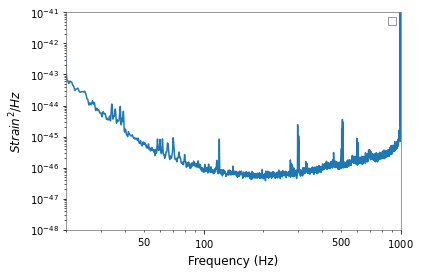

In [12]:
#Going through the motions
data = highpass(data, 20.0)
data = resample_to_delta_t(data, 1.0/2048)
conditioned = data.crop(2,2)

psd = conditioned.psd(4)
psd = interpolate(psd, conditioned.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=20)


pylab.plot(psd.sample_frequencies, psd)

pylab.yscale('log')
pylab.xscale('log')
pylab.ylim(1e-48, 1e-41)
pylab.xlim(20, 1000)
pylab.ylabel('$Strain^2 / Hz$')
pylab.xlabel('Frequency (Hz)')
pylab.grid()
pylab.legend()
pylab.show()

Well that doesn't imply anything necessarily. Let's plot the SNR to see if we can find something.

In [33]:
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=10,
                     mass2=10,
                     delta_t=conditioned.delta_t,
                     f_lower=30)

hp.resize(len(conditioned))
template = hp.cyclic_time_shift(hp.start_time)

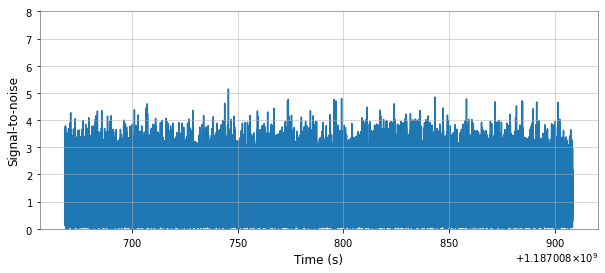

We found no signal with SNR higher than 8.


In [34]:
snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)

snr = snr.crop(4 + 4, 4)

pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylim(0,8)
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

if(abs(snrp) >= 8):
  print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))
else:
  print('We found no signal with SNR higher than 8.')

It appears there is no signal strong enough to be acknowledged as significant.

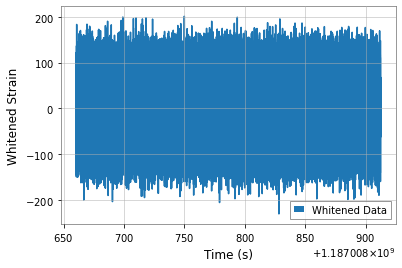

In [40]:
data = pycbc.types.timeseries.load_timeseries('/content/gdrive/My Drive/Google Colab/GW_noisedata-2.npy')
#To Whiten Data
high_data = data.highpass_fir(15, 2048)
psd = data.psd(4)

whitened = data.whiten(4, 4)

pylab.plot(whitened.sample_times, whitened, label='Whitened Data')

pylab.ylabel('Whitened Strain')
pylab.xlabel('Time (s)')
pylab.legend()
pylab.show()

Let's remove some of the additional noise shall we?

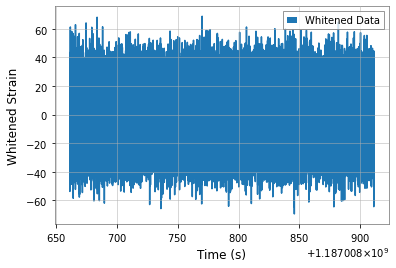

In [41]:
bpsd = whitened.highpass_fir(30, 2048).lowpass_fir(250, 2048)

pylab.plot(bpsd.sample_times, bpsd, label='Whitened Data')

pylab.ylabel('Whitened Strain')
pylab.xlabel('Time (s)')
pylab.legend()
pylab.show()

As expected, it looks like absolutely nothing. I am now deeply anxious about my results. That said, it's probably right.